# CNN

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# --- CÁC IMPORT TỪ PROJECT CỦA BẠN ---
import config
# Đảm bảo các hàm này được import đúng
from data_operations.data_preprocessing import import_cmmd_dataset 
from cnn_models.basic_cnn import create_basic_cnn_model 

# =================================================================
# BƯỚC 1: CẤU HÌNH VÀ TẢI LẠI MÔ HÌNH CNN ĐÃ HUẤN LUYỆN
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện cho CMMD ---")

# --- Đặt các thông số để tải đúng model ---
# LƯU Ý: Hãy thay thế bằng tên chính xác của file model CNN bạn đã lưu
MODEL_NAME_CMMD_CNN = 'CMMD_CNN_ReducedParams_Elastic1' # Ví dụ, thay bằng tên đúng
MODEL_PATH_CMMD_CNN = f'/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'

# Khởi tạo lại kiến trúc model rỗng
model_cnn_cmmd = None
try:
    # Tạo lại kiến trúc rỗng với đúng số lớp và kích thước ảnh
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224} # Cần set config này cho hàm create
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)
    # Tải trọng số đã huấn luyện vào kiến trúc này
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model CNN từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL CNN: {e}")
    print("\n==================== HƯỚNG DẪN SỬA LỖI ====================")
    print("1. KIỂM TRA LẠI ĐƯỜNG DẪN: Biến 'MODEL_PATH_CMMD_CNN' có chính xác chưa?")
    print("==========================================================")

# =================================================================
# BƯỚC 2: TẢI VÀ CHUẨN BỊ DỮ LIỆU TEST CỦA CMMD
# =================================================================
if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị dữ liệu CMMD để visualize ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['Benign', 'Malignant'])
    
    # Tải lại dữ liệu CMMD
    X_loaded_cmmd, y_numeric_labels_cmmd = import_cmmd_dataset(
        data_dir=DATA_DIR_CMMD,
        label_encoder=le_cmmd,
    )
    
    # Chia lại y hệt như lúc train để có tập test chính xác
    _, X_test_cmmd, _, y_test_numeric_cmmd = train_test_split(
        X_loaded_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42
    )
    print(f"Đã tải và chia xong, có {len(X_test_cmmd)} ảnh trong tập test CMMD.")

# =================================================================
# BƯỚC 3: ĐỊNH NGHĨA HÀM GRAD-CAM (Phiên bản nâng cấp)
# =================================================================

# --- Hàm make_gradcam_heatmap giữ nguyên, không cần sửa ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # ... (giữ nguyên code của hàm này)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# --- THAY THẾ HÀM display_gradcam CŨ BẰNG HÀM MỚI NÀY ---
def display_gradcam(original_img, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    """
    Hòa trộn heatmap lên ảnh gốc một cách "nghệ thuật" hơn.
    :param original_img: Ảnh gốc (dạng float, 3 kênh, giá trị [0, 1]).
    :param heatmap: Heatmap từ Grad-CAM (dạng float 2D, giá trị [0, 1]).
    :param alpha: Độ trong suốt của heatmap.
    :param colormap: Bảng màu của OpenCV để tô màu cho heatmap.
    :return: Ảnh đã được phủ heatmap.
    """
    # 1. Chuyển heatmap sang dạng ảnh màu
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_float = heatmap_color_rgb.astype(np.float32) / 255.0

    # 2. Chuyển ảnh gốc sang float32 nếu chưa phải
    img_float = original_img.astype(np.float32)

    # 3. Hòa trộn (blending)
    # Công thức: blended = (1 - alpha) * original + alpha * heatmap
    blended_img = (1 - alpha) * img_float + alpha * heatmap_float
    
    # 4. Tạo một mask từ heatmap để chỉ áp dụng hiệu ứng ở những vùng "nóng"
    # Điều này giữ cho các vùng nền đen không bị ám màu
    heatmap_mask = np.expand_dims(heatmap_resized, axis=-1)
    
    # 5. Kết hợp ảnh gốc và ảnh đã hòa trộn dựa trên mask
    # Vùng nào có heatmap > 0 thì dùng ảnh blended, còn lại dùng ảnh gốc
    superimposed_img = (img_float * (1 - heatmap_mask) + blended_img * heatmap_mask)
    
    # 6. Clip lại giá trị để đảm bảo nằm trong khoảng [0, 1] và trả về
    return np.clip(superimposed_img, 0, 1)


# =================================================================
# BƯỚC 4: TẠO VÀ HIỂN THỊ VISUALIZATION CHO CNN TRÊN CMMD
# =================================================================
if model_cnn_cmmd is not None and 'X_test_cmmd' in locals():
    print("\n--- 4. Tạo và hiển thị Grad-CAM cho mô hình CNN trên CMMD ---")
    
    # Tên của lớp conv cuối cùng trong mô hình Basic_CNN_Adjusted
    LAST_CONV_LAYER_NAME_CNN = "Conv2" 

    # Chọn ảnh mẫu từ tập test của CMMD
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    sample_indices = np.concatenate([
        np.random.choice(benign_indices, 2, replace=False),
        np.random.choice(malignant_indices, 2, replace=False)
    ])

    plt.figure(figsize=(12, 12))
    
    for i, img_idx in enumerate(sample_indices):
        # original_img đang có shape (224, 224, 1)
        original_img_with_channel = X_test_cmmd[img_idx] 
        
        # === SỬA LỖI Ở ĐÂY ===
        # Bóp (squeeze) chiều cuối cùng để có shape (224, 224) cho imshow
        original_img_2d = np.squeeze(original_img_with_channel, axis=-1)
        
        # Mô hình CNN của bạn nhận đầu vào 1 kênh, dữ liệu CMMD đã là 1 kênh
        img_array = np.expand_dims(original_img_with_channel, axis=0)

        # Dự đoán
        preds = model_cnn_cmmd.predict(img_array)
        predicted_class_idx = np.argmax(preds[0])
        predicted_class_name = le_cmmd.classes_[predicted_class_idx]
        true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]

        # Tạo heatmap
        heatmap = make_gradcam_heatmap(img_array, model_cnn_cmmd, LAST_CONV_LAYER_NAME_CNN)
        
        # Chuyển ảnh 2D sang 3 kênh để phủ màu
        img_to_display_3channel = cv2.cvtColor(original_img_2d.astype(np.float32), cv2.COLOR_GRAY2RGB)
        superimposed_img = display_gradcam(img_to_display_3channel, heatmap, alpha=0.5)

        # Hiển thị
        plt.subplot(4, 2, 2*i + 1)
        # Dùng ảnh 2D đã được squeeze để vẽ
        plt.imshow(original_img_2d, cmap='gray') 
        plt.title(f"Original CMMD - True: {true_class_name}")
        plt.axis('off')

        plt.subplot(4, 2, 2*i + 2)
        plt.imshow(superimposed_img)
        plt.title(f"Grad-CAM - Predicted: {predicted_class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    if model_cnn_cmmd is None:
        print("\n--> Do không tải được model, các bước tạo Grad-CAM đã được bỏ qua.")

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# --- CÁC IMPORT TỪ PROJECT CỦA BẠN ---
import config
# Đảm bảo các hàm này được import đúng
from data_operations.data_preprocessing import import_cmmd_dataset 
from cnn_models.basic_cnn import create_basic_cnn_model 

# =================================================================
# BƯỚC 1: CẤU HÌNH VÀ TẢI LẠI MÔ HÌNH CNN ĐÃ HUẤN LUYỆN
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện cho CMMD ---")

# --- Đặt các thông số để tải đúng model ---
# LƯU Ý: Hãy thay thế bằng tên chính xác của file model CNN bạn đã lưu
MODEL_NAME_CMMD_CNN = 'CMMD_CNN_ReducedParams_Elastic1' # Ví dụ, thay bằng tên đúng
MODEL_PATH_CMMD_CNN = f'/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'

# Khởi tạo lại kiến trúc model rỗng
model_cnn_cmmd = None
try:
    # Tạo lại kiến trúc rỗng với đúng số lớp và kích thước ảnh
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224} # Cần set config này cho hàm create
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)
    # Tải trọng số đã huấn luyện vào kiến trúc này
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model CNN từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL CNN: {e}")
    print("\n==================== HƯỚNG DẪN SỬA LỖI ====================")
    print("1. KIỂM TRA LẠI ĐƯỜNG DẪN: Biến 'MODEL_PATH_CMMD_CNN' có chính xác chưa?")
    print("==========================================================")

# =================================================================
# BƯỚC 2: TẢI VÀ CHUẨN BỊ DỮ LIỆU TEST CỦA CMMD
# =================================================================
if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị dữ liệu CMMD để visualize ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['Benign', 'Malignant'])
    
    # Tải lại dữ liệu CMMD
    X_loaded_cmmd, y_numeric_labels_cmmd = import_cmmd_dataset(
        data_dir=DATA_DIR_CMMD,
        label_encoder=le_cmmd,
    )
    
    # Chia lại y hệt như lúc train để có tập test chính xác
    _, X_test_cmmd, _, y_test_numeric_cmmd = train_test_split(
        X_loaded_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42
    )
    print(f"Đã tải và chia xong, có {len(X_test_cmmd)} ảnh trong tập test CMMD.")

# =================================================================
# BƯỚC 3: ĐỊNH NGHĨA HÀM GRAD-CAM (Phiên bản nâng cấp)
# =================================================================

# --- Hàm make_gradcam_heatmap giữ nguyên, không cần sửa ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # ... (giữ nguyên code của hàm này)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# --- THAY THẾ HÀM display_gradcam CŨ BẰNG HÀM MỚI NÀY ---
def display_gradcam(original_img, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    """
    Hòa trộn heatmap lên ảnh gốc một cách "nghệ thuật" hơn.
    :param original_img: Ảnh gốc (dạng float, 3 kênh, giá trị [0, 1]).
    :param heatmap: Heatmap từ Grad-CAM (dạng float 2D, giá trị [0, 1]).
    :param alpha: Độ trong suốt của heatmap.
    :param colormap: Bảng màu của OpenCV để tô màu cho heatmap.
    :return: Ảnh đã được phủ heatmap.
    """
    # 1. Chuyển heatmap sang dạng ảnh màu
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_float = heatmap_color_rgb.astype(np.float32) / 255.0

    # 2. Chuyển ảnh gốc sang float32 nếu chưa phải
    img_float = original_img.astype(np.float32)

    # 3. Hòa trộn (blending)
    # Công thức: blended = (1 - alpha) * original + alpha * heatmap
    blended_img = (1 - alpha) * img_float + alpha * heatmap_float
    
    # 4. Tạo một mask từ heatmap để chỉ áp dụng hiệu ứng ở những vùng "nóng"
    # Điều này giữ cho các vùng nền đen không bị ám màu
    heatmap_mask = np.expand_dims(heatmap_resized, axis=-1)
    
    # 5. Kết hợp ảnh gốc và ảnh đã hòa trộn dựa trên mask
    # Vùng nào có heatmap > 0 thì dùng ảnh blended, còn lại dùng ảnh gốc
    superimposed_img = (img_float * (1 - heatmap_mask) + blended_img * heatmap_mask)
    
    # 6. Clip lại giá trị để đảm bảo nằm trong khoảng [0, 1] và trả về
    return np.clip(superimposed_img, 0, 1)


# =================================================================
# BƯỚC 4: TẠO VÀ HIỂN THỊ VISUALIZATION CHO CNN TRÊN CMMD
# =================================================================
if model_cnn_cmmd is not None and 'X_test_cmmd' in locals():
    print("\n--- 4. Tạo và hiển thị Grad-CAM cho mô hình CNN trên CMMD ---")
    
    # Tên của lớp conv cuối cùng trong mô hình Basic_CNN_Adjusted
    LAST_CONV_LAYER_NAME_CNN = "Conv2" 

    # Chọn ảnh mẫu từ tập test của CMMD
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    sample_indices = np.concatenate([
        np.random.choice(benign_indices, 2, replace=False),
        np.random.choice(malignant_indices, 2, replace=False)
    ])

    plt.figure(figsize=(12, 12))
    
    for i, img_idx in enumerate(sample_indices):
        # original_img đang có shape (224, 224, 1)
        original_img_with_channel = X_test_cmmd[img_idx] 
        
        # === SỬA LỖI Ở ĐÂY ===
        # Bóp (squeeze) chiều cuối cùng để có shape (224, 224) cho imshow
        original_img_2d = np.squeeze(original_img_with_channel, axis=-1)
        
        # Mô hình CNN của bạn nhận đầu vào 1 kênh, dữ liệu CMMD đã là 1 kênh
        img_array = np.expand_dims(original_img_with_channel, axis=0)

        # Dự đoán
        preds = model_cnn_cmmd.predict(img_array)
        predicted_class_idx = np.argmax(preds[0])
        predicted_class_name = le_cmmd.classes_[predicted_class_idx]
        true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]

        # Tạo heatmap
        heatmap = make_gradcam_heatmap(img_array, model_cnn_cmmd, LAST_CONV_LAYER_NAME_CNN)
        
        # Chuyển ảnh 2D sang 3 kênh để phủ màu
        img_to_display_3channel = cv2.cvtColor(original_img_2d.astype(np.float32), cv2.COLOR_GRAY2RGB)
        superimposed_img = display_gradcam(img_to_display_3channel, heatmap, alpha=0.5)

        # Hiển thị
        plt.subplot(4, 2, 2*i + 1)
        # Dùng ảnh 2D đã được squeeze để vẽ
        plt.imshow(original_img_2d, cmap='gray') 
        plt.title(f"Original CMMD - True: {true_class_name}")
        plt.axis('off')

        plt.subplot(4, 2, 2*i + 2)
        plt.imshow(superimposed_img)
        plt.title(f"Grad-CAM - Predicted: {predicted_class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    if model_cnn_cmmd is None:
        print("\n--> Do không tải được model, các bước tạo Grad-CAM đã được bỏ qua.")

--- 1. Tải lại mô hình CNN đã huấn luyện cho CMMD ---

--- Basic CNN (Adjusted Output) Model Summary ---
Model: "Basic_CNN_Adjusted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 220, 220, 64)      1664      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 110, 110, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 110, 110, 32)      51232     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
Dropout_FC (Dropout)         (None, 96800)             0         
_________

: 

--- 1. Tải lại mô hình CNN đã huấn luyện ---

--- Basic CNN (Adjusted Output) Model Summary ---
Model: "Basic_CNN_Adjusted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 220, 220, 64)      1664      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 110, 110, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 110, 110, 32)      51232     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
Dropout_FC (Dropout)         (None, 96800)             0         
__________________

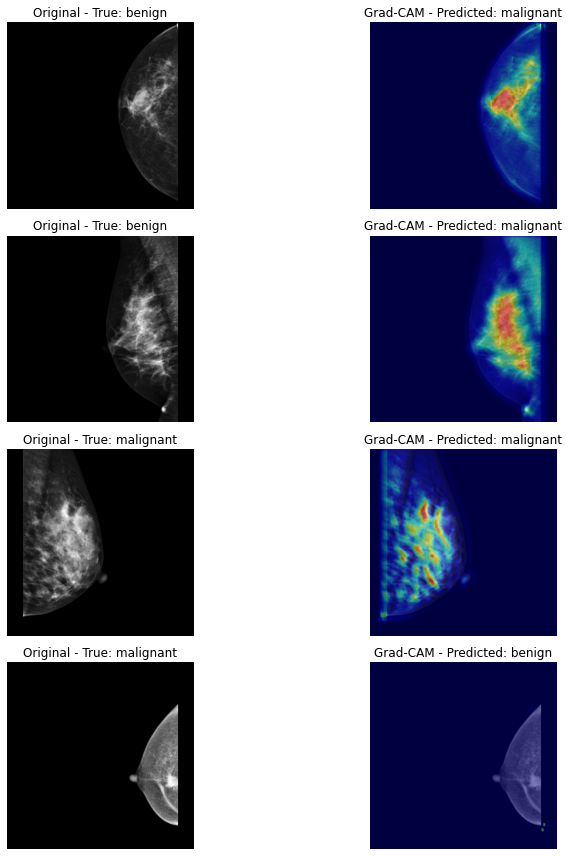

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import config
from cnn_models.basic_cnn import create_basic_cnn_model # Import hàm đã được sửa

# =================================================================
# BƯỚC 1: TẢI MODEL (ĐƠN GIẢN HÓA)
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện ---")

MODEL_PATH_CMMD_CNN = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'
model_cnn_cmmd = None

try:
    # ✅ Vì basic_cnn.py đã được sửa, chúng ta không cần mẹo build lại nữa.
    # Quy trình giờ rất đơn giản:
    # 1. Tạo kiến trúc model (đã được build đúng cách ngay từ đầu).
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224}
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)

    # 2. Tải trọng số.
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")

# =================================================================
# BƯỚC 2: CHỈ TẢI ĐƯỜNG DẪN ĐỂ TIẾT KIỆM BỘ NHỚ
# =================================================================
def get_image_paths_and_labels(data_dir, label_encoder):
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    return filepaths, label_encoder.transform(labels)

if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị đường dẫn dữ liệu CMMD ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    all_filepaths_cmmd, y_numeric_labels_cmmd = get_image_paths_and_labels(DATA_DIR_CMMD, le_cmmd)
    if len(all_filepaths_cmmd) > 0:
        _, X_test_filepaths, _, y_test_numeric_cmmd = train_test_split(all_filepaths_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42)
    else:
        X_test_filepaths = []

# =================================================================
# BƯỚC 3: HÀM GRAD-CAM (ĐƠN GIẢN HÓA)
# =================================================================
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # ✅ Vì model đã có cấu trúc phẳng, ta không cần truy cập model con nữa.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    return tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

def display_gradcam(original_img, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    superimposed_img = heatmap_color_rgb * alpha + original_img * (1 - alpha)
    return np.clip(superimposed_img, 0, 1)

# =================================================================
# BƯỚC 4: TẠO VISUALIZATION
# =================================================================
if model_cnn_cmmd is not None and 'X_test_filepaths' in locals() and len(X_test_filepaths) > 0:
    print("\n--- 4. Tạo và hiển thị Grad-CAM ---")
    LAST_CONV_LAYER_NAME_CNN = "Conv2"
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    
    if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
        sample_indices = np.concatenate([np.random.choice(benign_indices, 2, replace=False), np.random.choice(malignant_indices, 2, replace=False)])
        plt.figure(figsize=(12, 12))
        for i, img_idx in enumerate(sample_indices):
            image_path = X_test_filepaths[img_idx]
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            
            img_resized = cv2.resize(img, (config.ROI_IMG_SIZE['WIDTH'], config.ROI_IMG_SIZE['HEIGHT']))
            img_normalized = img_resized.astype(np.float32) / 255.0
            img_array = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)
            
            preds = model_cnn_cmmd.predict(img_array)
            heatmap = make_gradcam_heatmap(model_cnn_cmmd, img_array, LAST_CONV_LAYER_NAME_CNN)
            
            predicted_class_name = le_cmmd.classes_[np.argmax(preds[0])]
            true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]
            
            img_rgb_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
            superimposed_img = display_gradcam(img_rgb_normalized, heatmap)

            plt.subplot(4, 2, 2*i + 1); plt.imshow(img_normalized, cmap='gray'); plt.title(f"Original - True: {true_class_name}"); plt.axis('off')
            plt.subplot(4, 2, 2*i + 2); plt.imshow(superimposed_img); plt.title(f"Grad-CAM - Predicted: {predicted_class_name}"); plt.axis('off')
            
        plt.tight_layout(); plt.show()

--- 1. Tải lại mô hình CNN đã huấn luyện ---

--- Basic CNN (Adjusted Output) Model Summary ---
Model: "Basic_CNN_Adjusted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 220, 220, 64)      1664      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 110, 110, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 110, 110, 32)      51232     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
Dropout_FC (Dropout)         (None, 96800)             0         
__________________

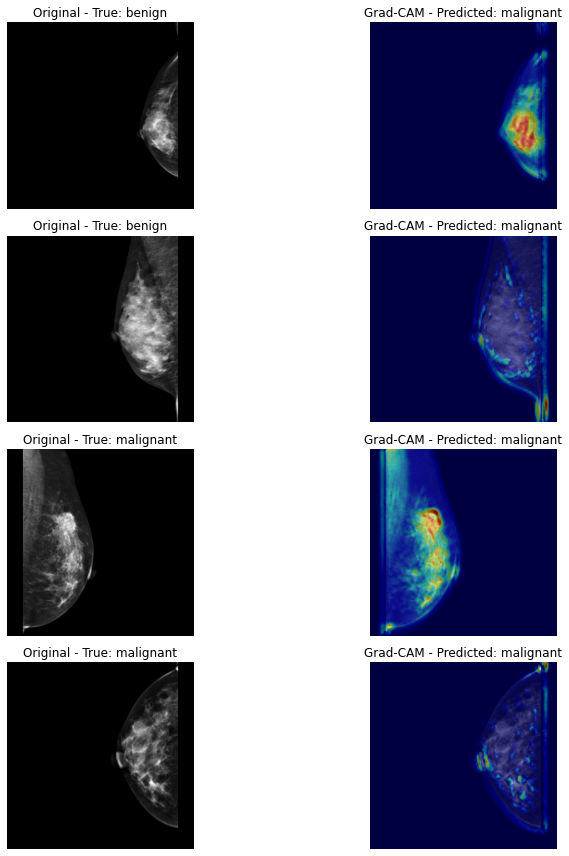

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import config
from cnn_models.basic_cnn import create_basic_cnn_model # Import hàm đã được sửa

# =================================================================
# BƯỚC 1: TẢI MODEL (ĐƠN GIẢN HÓA)
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện ---")

MODEL_PATH_CMMD_CNN = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'
model_cnn_cmmd = None

try:
    # ✅ Vì basic_cnn.py đã được sửa, chúng ta không cần mẹo build lại nữa.
    # Quy trình giờ rất đơn giản:
    # 1. Tạo kiến trúc model (đã được build đúng cách ngay từ đầu).
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224}
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)

    # 2. Tải trọng số.
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")

# =================================================================
# BƯỚC 2: CHỈ TẢI ĐƯỜNG DẪN ĐỂ TIẾT KIỆM BỘ NHỚ
# =================================================================
def get_image_paths_and_labels(data_dir, label_encoder):
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    return filepaths, label_encoder.transform(labels)

if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị đường dẫn dữ liệu CMMD ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    all_filepaths_cmmd, y_numeric_labels_cmmd = get_image_paths_and_labels(DATA_DIR_CMMD, le_cmmd)
    if len(all_filepaths_cmmd) > 0:
        _, X_test_filepaths, _, y_test_numeric_cmmd = train_test_split(all_filepaths_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42)
    else:
        X_test_filepaths = []

# =================================================================
# BƯỚC 3: HÀM GRAD-CAM (ĐƠN GIẢN HÓA)
# =================================================================
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # ✅ Vì model đã có cấu trúc phẳng, ta không cần truy cập model con nữa.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    return tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

def display_gradcam(original_img, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    superimposed_img = heatmap_color_rgb * alpha + original_img * (1 - alpha)
    return np.clip(superimposed_img, 0, 1)

# =================================================================
# BƯỚC 4: TẠO VISUALIZATION
# =================================================================
if model_cnn_cmmd is not None and 'X_test_filepaths' in locals() and len(X_test_filepaths) > 0:
    print("\n--- 4. Tạo và hiển thị Grad-CAM ---")
    LAST_CONV_LAYER_NAME_CNN = "Conv2"
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    
    if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
        sample_indices = np.concatenate([np.random.choice(benign_indices, 2, replace=False), np.random.choice(malignant_indices, 2, replace=False)])
        plt.figure(figsize=(12, 12))
        for i, img_idx in enumerate(sample_indices):
            image_path = X_test_filepaths[img_idx]
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            
            img_resized = cv2.resize(img, (config.ROI_IMG_SIZE['WIDTH'], config.ROI_IMG_SIZE['HEIGHT']))
            img_normalized = img_resized.astype(np.float32) / 255.0
            img_array = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)
            
            preds = model_cnn_cmmd.predict(img_array)
            heatmap = make_gradcam_heatmap(model_cnn_cmmd, img_array, LAST_CONV_LAYER_NAME_CNN)
            
            predicted_class_name = le_cmmd.classes_[np.argmax(preds[0])]
            true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]
            
            img_rgb_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
            superimposed_img = display_gradcam(img_rgb_normalized, heatmap)

            plt.subplot(4, 2, 2*i + 1); plt.imshow(img_normalized, cmap='gray'); plt.title(f"Original - True: {true_class_name}"); plt.axis('off')
            plt.subplot(4, 2, 2*i + 2); plt.imshow(superimposed_img); plt.title(f"Grad-CAM - Predicted: {predicted_class_name}"); plt.axis('off')
            
        plt.tight_layout(); plt.show()

--- 1. Tải lại mô hình CNN đã huấn luyện ---

--- Basic CNN (Adjusted Output) Model Summary ---
Model: "Basic_CNN_Adjusted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 220, 220, 64)      1664      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 110, 110, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 110, 110, 32)      51232     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
Dropout_FC (Dropout)         (None, 96800)             0         
__________________

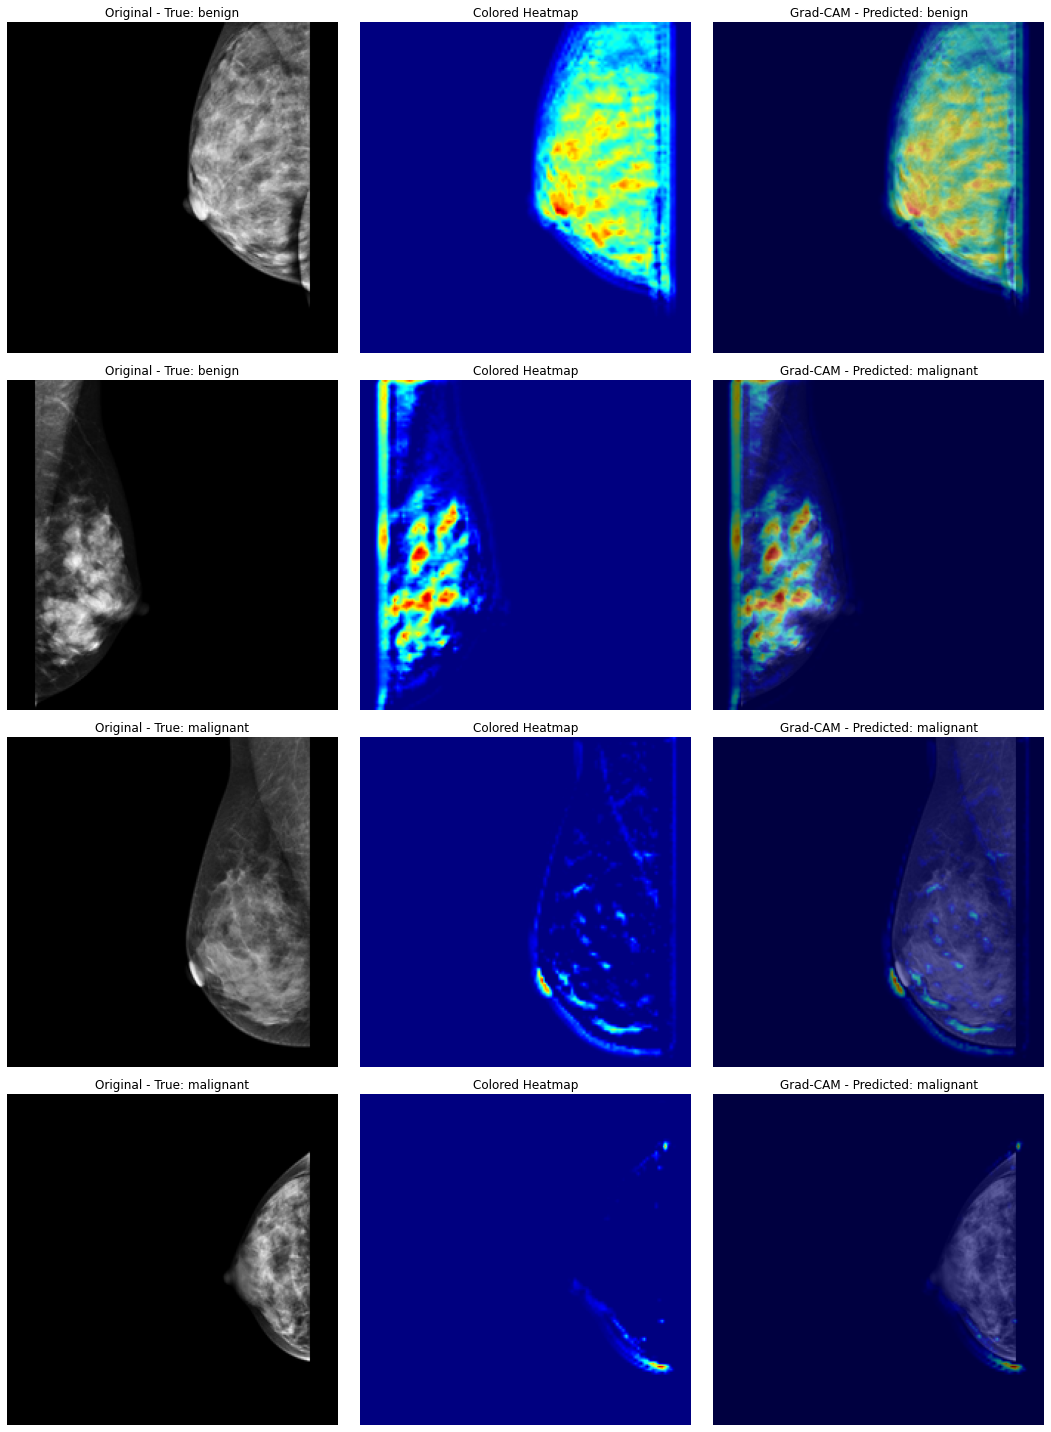

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import config
from cnn_models.basic_cnn import create_basic_cnn_model # Import hàm đã được sửa

# =================================================================
# BƯỚC 1: TẢI MODEL (ĐƠN GIẢN HÓA)
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện ---")

MODEL_PATH_CMMD_CNN = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'
model_cnn_cmmd = None

try:
    # Vì basic_cnn.py đã được sửa, chúng ta không cần mẹo build lại nữa.
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224}
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)

    # Tải trọng số.
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")

# =================================================================
# BƯỚC 2: CHỈ TẢI ĐƯỜNG DẪN ĐỂ TIẾT KIỆM BỘ NHỚ
# =================================================================
def get_image_paths_and_labels(data_dir, label_encoder):
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    return filepaths, label_encoder.transform(labels)

if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị đường dẫn dữ liệu CMMD ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    all_filepaths_cmmd, y_numeric_labels_cmmd = get_image_paths_and_labels(DATA_DIR_CMMD, le_cmmd)
    if len(all_filepaths_cmmd) > 0:
        _, X_test_filepaths, _, y_test_numeric_cmmd = train_test_split(all_filepaths_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42)
    else:
        X_test_filepaths = []

# =================================================================
# BƯỚC 3: HÀM GRAD-CAM (ĐƠN GIẢN HÓA)
# =================================================================
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    return tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

def display_gradcam(original_img, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    superimposed_img = heatmap_color_rgb * alpha + original_img * (1 - alpha)
    return np.clip(superimposed_img, 0, 1)

# =================================================================
# BƯỚC 4: TẠO VISUALIZATION (ĐÃ CẬP NHẬT)
# =================================================================
if model_cnn_cmmd is not None and 'X_test_filepaths' in locals() and len(X_test_filepaths) > 0:
    print("\n--- 4. Tạo và hiển thị Grad-CAM ---")
    LAST_CONV_LAYER_NAME_CNN = "Conv2"
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    
    if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
        sample_indices = np.concatenate([np.random.choice(benign_indices, 2, replace=False), np.random.choice(malignant_indices, 2, replace=False)])
        
        # ✅ Thay đổi kích thước và bố cục biểu đồ
        num_samples = len(sample_indices)
        plt.figure(figsize=(15, 5 * num_samples)) # Rộng hơn để chứa 3 cột
        
        for i, img_idx in enumerate(sample_indices):
            image_path = X_test_filepaths[img_idx]
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            
            img_resized = cv2.resize(img, (config.ROI_IMG_SIZE['WIDTH'], config.ROI_IMG_SIZE['HEIGHT']))
            img_normalized = img_resized.astype(np.float32) / 255.0
            img_array = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)
            
            preds = model_cnn_cmmd.predict(img_array)
            heatmap = make_gradcam_heatmap(model_cnn_cmmd, img_array, LAST_CONV_LAYER_NAME_CNN)
            
            predicted_class_name = le_cmmd.classes_[np.argmax(preds[0])]
            true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]
            
            # --- Chuẩn bị ảnh cho các cột ---
            # 1. Ảnh gốc (đã có)
            # 2. Ảnh heatmap đã tô màu (cho cột giữa)
            heatmap_resized = cv2.resize(heatmap.numpy(), (img_normalized.shape[1], img_normalized.shape[0]))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            heatmap_colored_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
            
            # 3. Ảnh Grad-CAM (trộn heatmap và ảnh gốc)
            img_rgb_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
            superimposed_img = display_gradcam(img_rgb_normalized, heatmap)

            # --- Vẽ 3 cột ---
            # Cột 1: Ảnh gốc
            plt.subplot(num_samples, 3, 3*i + 1)
            plt.imshow(img_normalized, cmap='gray')
            plt.title(f"Original - True: {true_class_name}")
            plt.axis('off')
            
            # Cột 2: Heatmap đã tô màu
            plt.subplot(num_samples, 3, 3*i + 2)
            plt.imshow(heatmap_colored_rgb)
            plt.title("Colored Heatmap")
            plt.axis('off')

            # Cột 3: Ảnh Grad-CAM
            plt.subplot(num_samples, 3, 3*i + 3)
            plt.imshow(superimposed_img)
            plt.title(f"Grad-CAM - Predicted: {predicted_class_name}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

--- 1. Tải lại mô hình CNN đã huấn luyện ---

--- Basic CNN (Adjusted Output) Model Summary ---
Model: "Basic_CNN_Adjusted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 220, 220, 64)      1664      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 110, 110, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 110, 110, 32)      51232     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 96800)             0         
_________________________________________________________________
Dropout_FC (Dropout)         (None, 96800)             0         
__________________

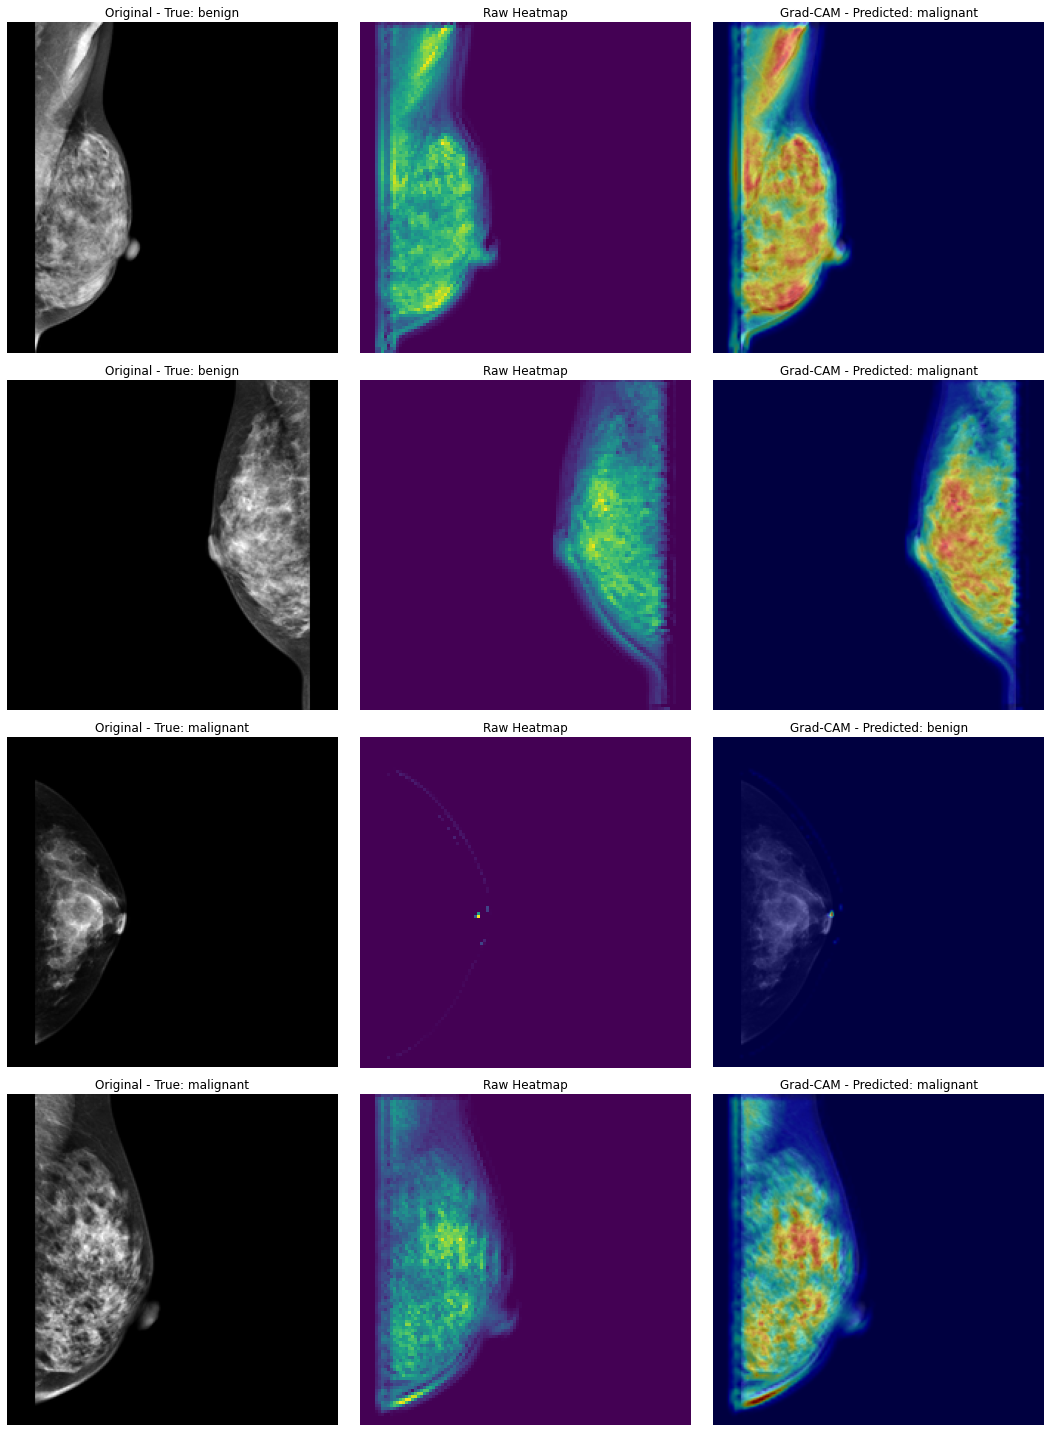

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import config
from cnn_models.basic_cnn import create_basic_cnn_model # Import hàm đã được sửa

# =================================================================
# BƯỚC 1: TẢI MODEL (ĐƠN GIẢN HÓA)
# =================================================================
print("--- 1. Tải lại mô hình CNN đã huấn luyện ---")

MODEL_PATH_CMMD_CNN = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-CNN_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_CNN_ReducedParams_Elastic1.weights.h5'
model_cnn_cmmd = None

try:
    # Vì basic_cnn.py đã được sửa, chúng ta không cần mẹo build lại nữa.
    config.ROI_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224}
    model_cnn_cmmd = create_basic_cnn_model(num_classes=2)

    # Tải trọng số.
    model_cnn_cmmd.load_weights(MODEL_PATH_CMMD_CNN)
    print(f"\n--- Tải thành công model từ: {MODEL_PATH_CMMD_CNN} ---")
    model_cnn_cmmd.summary()

except Exception as e:
    print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")

# =================================================================
# BƯỚC 2: CHỈ TẢI ĐƯỜNG DẪN ĐỂ TIẾT KIỆM BỘ NHỚ
# =================================================================
def get_image_paths_and_labels(data_dir, label_encoder):
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    return filepaths, label_encoder.transform(labels)

if model_cnn_cmmd is not None:
    print("\n--- 2. Chuẩn bị đường dẫn dữ liệu CMMD ---")
    DATA_DIR_CMMD = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    all_filepaths_cmmd, y_numeric_labels_cmmd = get_image_paths_and_labels(DATA_DIR_CMMD, le_cmmd)
    if len(all_filepaths_cmmd) > 0:
        _, X_test_filepaths, _, y_test_numeric_cmmd = train_test_split(all_filepaths_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42)
    else:
        X_test_filepaths = []

# =================================================================
# BƯỚC 3: HÀM GRAD-CAM (ĐƠN GIẢN HÓA)
# =================================================================
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    return tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

def display_gradcam(original_img, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    superimposed_img = heatmap_color_rgb * alpha + original_img * (1 - alpha)
    return np.clip(superimposed_img, 0, 1)

# =================================================================
# BƯỚC 4: TẠO VISUALIZATION (ĐÃ CẬP NHẬT THEO YÊU CẦU)
# =================================================================
if model_cnn_cmmd is not None and 'X_test_filepaths' in locals() and len(X_test_filepaths) > 0:
    print("\n--- 4. Tạo và hiển thị Grad-CAM ---")
    LAST_CONV_LAYER_NAME_CNN = "Conv2"
    benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
    malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
    
    if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
        sample_indices = np.concatenate([np.random.choice(benign_indices, 2, replace=False), np.random.choice(malignant_indices, 2, replace=False)])
        
        num_samples = len(sample_indices)
        plt.figure(figsize=(15, 5 * num_samples))
        
        for i, img_idx in enumerate(sample_indices):
            image_path = X_test_filepaths[img_idx]
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            
            img_resized = cv2.resize(img, (config.ROI_IMG_SIZE['WIDTH'], config.ROI_IMG_SIZE['HEIGHT']))
            img_normalized = img_resized.astype(np.float32) / 255.0
            img_array = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)
            
            preds = model_cnn_cmmd.predict(img_array)
            # `heatmap` ở đây là heatmap gốc, có độ phân giải thấp
            heatmap = make_gradcam_heatmap(model_cnn_cmmd, img_array, LAST_CONV_LAYER_NAME_CNN)
            
            predicted_class_name = le_cmmd.classes_[np.argmax(preds[0])]
            true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]
            
            # Chuẩn bị ảnh Grad-CAM để trộn
            img_rgb_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
            superimposed_img = display_gradcam(img_rgb_normalized, heatmap)

            # --- Vẽ 3 cột ---
            # Cột 1: Ảnh gốc
            plt.subplot(num_samples, 3, 3*i + 1)
            plt.imshow(img_normalized, cmap='gray')
            plt.title(f"Original - True: {true_class_name}")
            plt.axis('off')
            
            # ✅ Cột 2: Heatmap gốc (chưa tô màu, chưa resize)
            # Dùng colormap 'viridis' hoặc 'jet' để thấy rõ các vùng nóng
            plt.subplot(num_samples, 3, 3*i + 2)
            plt.imshow(heatmap.numpy(), cmap='viridis') # Thay đổi ở đây
            plt.title("Raw Heatmap")
            plt.axis('off')

            # Cột 3: Ảnh Grad-CAM (đã trộn)
            plt.subplot(num_samples, 3, 3*i + 3)
            plt.imshow(superimposed_img)
            plt.title(f"Grad-CAM - Predicted: {predicted_class_name}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# MobileNet

In [28]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import argparse
# --- CÁC IMPORT TỪ PROJECT CỦA BẠN ---
# Giả định script này nằm cùng cấp với thư mục 'src',
# hoặc bạn đã thêm 'src' vào PYTHONPATH
try:
    from src import config
    from src.data_operations.data_preprocessing import import_cmmd_dataset
    from src.cnn_models.mobilenet_v2 import create_mobilenet_model
except ImportError:
    print("Lỗi: Không tìm thấy các module từ 'src'. Hãy đảm bảo bạn chạy script này từ thư mục gốc của project hoặc thêm 'src' vào PYTHONPATH của bạn.")
    # You might want to add sys.path.append(os.path.abspath('../')) if your notebook is in a subfolder
    # For example, if your notebook is in 'notebooks/' and 'src/' is at the project root.
    # import sys
    # sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
    # from src import config
    # from src.data_operations.data_preprocessing import import_cmmd_dataset
    # from src.cnn_models.mobilenet_v2 import create_mobilenet_model
    exit()

# =================================================================
# HÀM GRAD-CAM
# =================================================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Tạo heatmap Grad-CAM cho một ảnh.

    Args:
        img_array (np.array): Ảnh đầu vào (đã được tiền xử lý) dưới dạng numpy array.
        model (tf.keras.Model): Mô hình đã huấn luyện.
        last_conv_layer_name (str): Tên của lớp convolutional cuối cùng trong mô hình.
        pred_index (int, optional): Chỉ số của lớp muốn tạo Grad-CAM.
                                     Nếu None, sẽ sử dụng lớp dự đoán cao nhất.

    Returns:
        np.array: Heatmap Grad-CAM.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Tính toán độ dốc của đầu ra lớp dự đoán đối với đầu ra lớp conv cuối
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Gộp độ dốc trung bình theo các chiều không gian
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Nhân đầu ra lớp conv cuối với độ dốc đã gộp để tạo heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap) # Loại bỏ chiều đơn
    
    # Chuẩn hóa heatmap về khoảng [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(original_img, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    """
    Hiển thị ảnh gốc đã phủ heatmap Grad-CAM.

    Args:
        original_img (np.array): Ảnh gốc (RGB).
        heatmap (np.array): Heatmap Grad-CAM.
        alpha (float, optional): Độ trong suốt của heatmap. Mặc định là 0.6.
        colormap (int, optional): Colormap của OpenCV. Mặc định là cv2.COLORMAP_JET.

    Returns:
        np.array: Ảnh đã phủ heatmap, đã chuẩn hóa về khoảng [0, 1].
    """
    # Thay đổi kích thước heatmap để khớp với ảnh gốc
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    # Áp dụng colormap cho heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    
    # Chuyển đổi từ BGR sang RGB (OpenCV dùng BGR theo mặc định)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Chuẩn hóa heatmap và ảnh gốc về [0, 1] cho phép trộn
    heatmap_float = heatmap_color_rgb.astype(np.float32) / 255.0
    img_float = original_img.astype(np.float32)
    
    # Trộn ảnh gốc và heatmap
    blended_img = (1 - alpha) * img_float + alpha * heatmap_float
    
    # Áp dụng mask để chỉ phủ heatmap lên các vùng quan trọng
    # Đây là một cách khác để trộn, đảm bảo heatmap chỉ xuất hiện ở những vùng có giá trị cao.
    # Tuy nhiên, cách trộn tuyến tính (blended_img) thường được dùng hơn trong Grad-CAM
    # Nếu bạn muốn heatmap chỉ xuất hiện ở các vùng có giá trị > 0, bạn có thể uncomment dòng dưới
    # và sử dụng nó thay cho blended_img trực tiếp trong plt.imshow
    # superimposed_img = (img_float * (1 - heatmap_mask) + blended_img * heatmap_mask)
    
    # Đảm bảo giá trị ảnh nằm trong khoảng [0, 1]
    return np.clip(blended_img, 0, 1)

# =================================================================
# THIẾT LẬP THAM SỐ VÀ CHẠY
# =================================================================

# Đặt đường dẫn đến model và dữ liệu của bạn ở đây
# Bạn có thể điều chỉnh các đường dẫn này tùy thuộc vào cấu trúc project của bạn
MODEL_PATH = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-MobileNet_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_MobileNet_ReducedParams_Elastic2.h5' # Ví dụ: Đường dẫn tới file model đã huấn luyện
DATA_DIR = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD' # Ví dụ: Đường dẫn tới thư mục chứa dữ liệu CMMD

print("--- Bắt đầu quy trình Grad-CAM ---")

# --- 1. Tải lại mô hình MobileNet đã huấn luyện cho CMMD ---
print("--- 1. Tải lại mô hình MobileNet đã huấn luyện cho CMMD ---")
if not os.path.exists(MODEL_PATH):
    print(f"[LỖI] Không tìm thấy file model tại: {MODEL_PATH}")
    print("Vui lòng kiểm tra lại đường dẫn và đảm bảo bạn đã huấn luyện mô hình.")
else:
    model_cmmd = None
    try:
        # Cập nhật cấu hình từ module src.config
        # Đảm bảo rằng config.dataset và config.model được thiết lập đúng trước khi tạo model
        config.dataset = "CMMD"
        config.model = "MobileNet"
        config.verbose_mode = False # Tắt bớt log thừa từ config
        
        # Tạo kiến trúc MobileNet và tải trọng số
        model_cmmd = create_mobilenet_model(num_classes=2)
        model_cmmd.load_weights(MODEL_PATH)
        print(f"\n--- Tải thành công model MobileNet từ: {MODEL_PATH} ---")
    except Exception as e:
        print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL MOBILENET: {e}")
        model_cmmd = None # Đảm bảo model là None nếu tải lỗi

if model_cmmd is None:
    print("Không thể tiếp tục vì không tải được mô hình.")

else:
    # --- 2. Tải và chuẩn bị dữ liệu TEST của CMMD ---
    print("\n--- 2. Chuẩn bị dữ liệu CMMD để visualize ---")
    if not os.path.isdir(DATA_DIR):
        print(f"[LỖI] Không tìm thấy thư mục dữ liệu tại: {DATA_DIR}")
        print("Vui lòng kiểm tra lại đường dẫn và đảm bảo thư mục dữ liệu tồn tại.")
    else:
        le_cmmd = LabelEncoder()
        le_cmmd.fit(['Benign', 'Malignant'])
        
        X_loaded_cmmd, y_numeric_labels_cmmd = import_cmmd_dataset(
            data_dir=DATA_DIR, label_encoder=le_cmmd
        )
        
        # Chia tập dữ liệu thành train và test
        # Lấy 20% dữ liệu cho tập test, đảm bảo phân bố lớp cân bằng (stratify)
        _, X_test_cmmd, _, y_test_numeric_cmmd = train_test_split(
            X_loaded_cmmd, y_numeric_labels_cmmd, test_size=0.2, stratify=y_numeric_labels_cmmd, random_state=42
        )
        print(f"Đã tải và chia xong, có {len(X_test_cmmd)} ảnh trong tập test CMMD.")

        # --- 3. Tạo và hiển thị Grad-CAM ---
        print("\n--- 3. Tạo và hiển thị Grad-CAM cho mô hình MobileNet trên CMMD ---")
        LAST_CONV_LAYER_NAME = "out_relu" # Lớp convolutional cuối của MobileNetV2

        benign_indices = np.where(y_test_numeric_cmmd == 0)[0]
        malignant_indices = np.where(y_test_numeric_cmmd == 1)[0]
        
        # Lấy 2 ảnh Benign và 2 ảnh Malignant ngẫu nhiên từ tập test để visualize
        if len(benign_indices) < 2 or len(malignant_indices) < 2:
            print("Không đủ mẫu Benign hoặc Malignant (cần ít nhất 2 mẫu mỗi loại) để visualize.")
        else:
            sample_indices = np.concatenate([
                np.random.choice(benign_indices, 2, replace=False),
                np.random.choice(malignant_indices, 2, replace=False)
            ])

            plt.figure(figsize=(15, 5 * len(sample_indices))) # Điều chỉnh kích thước figure
            for i, img_idx in enumerate(sample_indices):
                original_img_gray = X_test_cmmd[img_idx]
                
                # Expand dimensions to match model input shape (batch_size, height, width, channels)
                # For grayscale, it should be (1, H, W, 1)
                img_array_for_prediction = np.expand_dims(original_img_gray, axis=0)
                img_array_for_prediction = np.expand_dims(img_array_for_prediction, axis=-1) # Add channel dimension
                
                # Dự đoán lớp cho ảnh
                preds = model_cmmd.predict(img_array_for_prediction)
                predicted_class_idx = np.argmax(preds[0])
                predicted_class_name = le_cmmd.classes_[predicted_class_idx]
                true_class_name = le_cmmd.classes_[y_test_numeric_cmmd[img_idx]]

                # Tạo heatmap Grad-CAM
                heatmap_raw = make_gradcam_heatmap(img_array_for_prediction, model_cmmd, LAST_CONV_LAYER_NAME)
                
                # Chuyển ảnh xám sang RGB để hiển thị và phủ màu
                # cv2.cvtColor yêu cầu ảnh đầu vào là uint8 hoặc float32
                img_to_display = cv2.cvtColor(original_img_gray.astype(np.float32), cv2.COLOR_GRAY2RGB)
                
                # Phủ heatmap lên ảnh gốc
                superimposed_img = display_gradcam(img_to_display, heatmap_raw, alpha=0.5)

                # Hiển thị kết quả trên subplot
                # Cột 1: Ảnh gốc
                plt.subplot(len(sample_indices), 3, 3*i + 1)
                plt.imshow(img_to_display)
                plt.title(f"Original CMMD - True: {true_class_name}")
                plt.axis('off')

                # Cột 2: Heatmap thô
                plt.subplot(len(sample_indices), 3, 3*i + 2)
                plt.imshow(heatmap_raw, cmap='viridis') # 'viridis' là một colormap tốt cho heatmap
                plt.title("Raw Heatmap")
                plt.axis('off')

                # Cột 3: Ảnh đã phủ heatmap (Grad-CAM)
                plt.subplot(len(sample_indices), 3, 3*i + 3)
                plt.imshow(superimposed_img)
                plt.title(f"Grad-CAM - Predicted: {predicted_class_name}")
                plt.axis('off')

            plt.tight_layout() # Tự động điều chỉnh layout để tránh chồng chéo
            plt.show()

print("\n--- Quy trình Grad-CAM hoàn tất ---")

Lỗi: Không tìm thấy các module từ 'src'. Hãy đảm bảo bạn chạy script này từ thư mục gốc của project hoặc thêm 'src' vào PYTHONPATH của bạn.
--- Bắt đầu quy trình Grad-CAM ---
--- 1. Tải lại mô hình MobileNet đã huấn luyện cho CMMD ---

[LỖI] KHÔNG THỂ TẢI MODEL MOBILENET: ('Invalid keyword argument: %s', 'name')
Không thể tiếp tục vì không tải được mô hình.

--- Quy trình Grad-CAM hoàn tất ---


: 

--- Tải lại mô hình MobileNet ---


/tmp/ipykernel_62574/173400033.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet_app = MobileNetV2(input_tensor=tensor_fed_to_mobilenet_base,



--- Tải thành công model MobileNet ---


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 224, 224,  │          0 │ input_layer_39[0… │
│ (Concatenate)       │ 3)                │            │ input_layer_39[0… │
│                     │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ concatenate_22[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,930,338 (11.18 MB)

 Trainable params: 2,896,226 (11.05 MB)

 Non-trainable params: 34,112 (133.25 KB)

Bắt đầu quét thư mục: /home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD
Đã tìm thấy 5322 ảnh.

Đã chia xong, có 1065 ảnh trong tập test.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3576']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3576']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3576']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3576']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


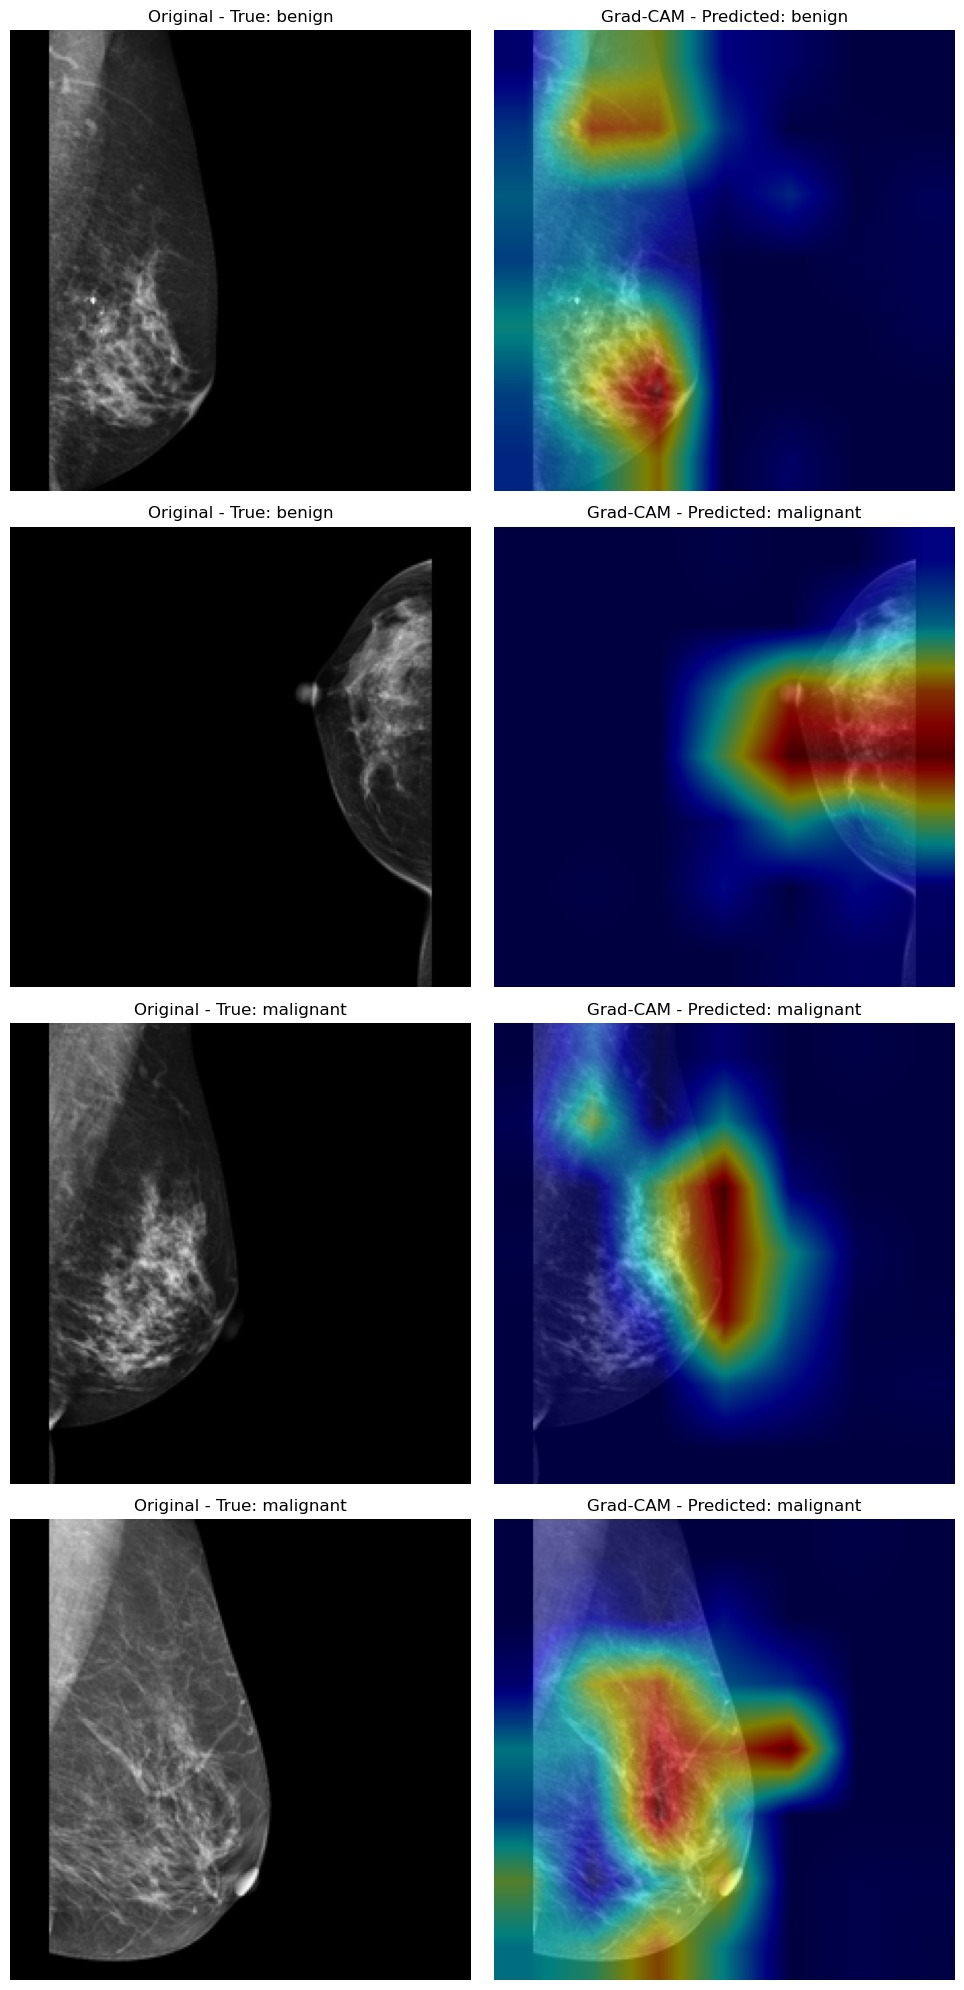

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# =================================================================
# BƯỚC 1: ĐỊNH NGHĨA CÁC HÀM CẦN THIẾT
# =================================================================

def create_mobilenet_model(num_classes: int, img_height=224, img_width=224):
    """
    Hàm tạo model MobileNet.
    Model này nhận đầu vào là ảnh xám (1 kênh) và tự chuyển thành 3 kênh.
    """
    # Đầu vào của model tổng thể là 1 kênh
    final_model_input_layer = Input(shape=(img_height, img_width, 1))
    
    # Nhân bản thành 3 kênh để đưa vào MobileNet base
    tensor_fed_to_mobilenet_base = Concatenate()([
        final_model_input_layer, 
        final_model_input_layer, 
        final_model_input_layer
    ])

    # Khởi tạo MobileNetV2 base
    base_mobilenet_app = MobileNetV2(input_tensor=tensor_fed_to_mobilenet_base, 
                                     include_top=False,
                                     weights='imagenet')

    x = base_mobilenet_app.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    if num_classes >= 2:
        out = Dense(num_classes, activation='softmax')(x)
    else: 
        out = Dense(1, activation='sigmoid')(x)
            
    final_model = Model(inputs=final_model_input_layer, outputs=out)
            
    return final_model

def get_image_paths_and_labels(data_dir, label_encoder):
    """
    Hàm này chỉ lấy đường dẫn file, không tải ảnh, giúp tiết kiệm RAM.
    """
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    print(f"Bắt đầu quét thư mục: {data_dir}")
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"[Cảnh báo] Không tìm thấy thư mục lớp: '{class_name}'")
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    print(f"Đã tìm thấy {len(filepaths)} ảnh.")
    return filepaths, label_encoder.transform(labels)

def make_gradcam_heatmap(model, img_array, last_conv_layer_name):
    """
    Hàm Grad-CAM phiên bản đơn giản và ổn định.
    Nó hoạt động tốt với cấu trúc model "phẳng" của bạn.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(original_img_rgb, heatmap, alpha=0.5):
    """Hàm trộn màu heatmap lên ảnh gốc."""
    heatmap_resized = cv2.resize(heatmap, (original_img_rgb.shape[1], original_img_rgb.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Chuyển ảnh gốc sang kiểu float32 để trộn
    img_float = original_img_rgb.astype(np.float32)
    heatmap_float = heatmap_color_rgb.astype(np.float32)
    
    superimposed_img = heatmap_float * alpha + img_float * (1 - alpha)
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)


# =================================================================
# BƯỚC 2: THIẾT LẬP VÀ CHẠY QUY TRÌNH
# =================================================================

# --- 1. Cấu hình đường dẫn ---
MODEL_PATH = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-MobileNet_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_MobileNet_ReducedParams_Elastic2.h5'
DATA_DIR = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
LAST_CONV_LAYER_NAME = "out_relu" # Lớp kích hoạt cuối cùng trong MobileNetV2 base

# --- 2. Tải model ---
print("--- Tải lại mô hình MobileNet ---")
model_mobilenet = None
if not os.path.exists(MODEL_PATH):
    print(f"[LỖI] Không tìm thấy file model tại: {MODEL_PATH}")
else:
    try:
        model_mobilenet = create_mobilenet_model(num_classes=2)
        model_mobilenet.load_weights(MODEL_PATH)
        print("\n--- Tải thành công model MobileNet ---")
        model_mobilenet.summary()
    except Exception as e:
        print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")
        import traceback
        traceback.print_exc()

# --- 3. Tải đường dẫn dữ liệu và visualize ---
if model_mobilenet is not None:
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    
    # ✅ Chỉ lấy đường dẫn, không tải ảnh
    all_filepaths, y_labels = get_image_paths_and_labels(DATA_DIR, le_cmmd)
    
    if len(all_filepaths) > 0:
        _, X_test_filepaths, _, y_test_labels = train_test_split(
            all_filepaths, y_labels, test_size=0.2, stratify=y_labels, random_state=42
        )
        print(f"\nĐã chia xong, có {len(X_test_filepaths)} ảnh trong tập test.")

        # Chọn mẫu để visualize
        benign_indices = np.where(y_test_labels == le_cmmd.transform(['benign'])[0])[0]
        malignant_indices = np.where(y_test_labels == le_cmmd.transform(['malignant'])[0])[0]
        
        if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
            sample_indices = np.concatenate([
                np.random.choice(benign_indices, 2, replace=False),
                np.random.choice(malignant_indices, 2, replace=False)
            ])

            plt.figure(figsize=(10, 5 * len(sample_indices)))
            for i, idx in enumerate(sample_indices):
                # ✅ Tải và xử lý từng ảnh một để tiết kiệm RAM
                image_path = X_test_filepaths[idx]
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Cảnh báo: Không thể đọc ảnh {image_path}")
                    continue
                
                img_resized = cv2.resize(img, (224, 224))
                
                # Chuẩn bị ảnh cho model (thêm chiều batch và channel)
                img_array_for_model = np.expand_dims(img_resized, axis=-1).astype(np.float32)
                img_array_for_model = np.expand_dims(img_array_for_model, axis=0)

                # Dự đoán và tạo heatmap
                preds = model_mobilenet.predict(img_array_for_model)
                heatmap = make_gradcam_heatmap(model_mobilenet, img_array_for_model, LAST_CONV_LAYER_NAME)
                
                # Chuẩn bị ảnh để hiển thị
                predicted_class = le_cmmd.inverse_transform([np.argmax(preds[0])])[0]
                true_class = le_cmmd.inverse_transform([y_test_labels[idx]])[0]
                
                img_to_display = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
                superimposed_img = display_gradcam(img_to_display, heatmap)

                # Vẽ kết quả
                plt.subplot(len(sample_indices), 2, 2*i + 1)
                plt.imshow(img_to_display)
                plt.title(f"Original - True: {true_class}")
                plt.axis('off')

                plt.subplot(len(sample_indices), 2, 2*i + 2)
                plt.imshow(superimposed_img)
                plt.title(f"Grad-CAM - Predicted: {predicted_class}")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("Không đủ mẫu 'Benign' hoặc 'Malignant' trong tập test để visualize.")
    else:
        print("Không tìm thấy ảnh nào, không thể thực hiện visualization.")

--- Tải lại mô hình MobileNet ---


/tmp/ipykernel_62574/173400033.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet_app = MobileNetV2(input_tensor=tensor_fed_to_mobilenet_base,



--- Tải thành công model MobileNet ---


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 224, 224,  │          0 │ input_layer_38[0… │
│ (Concatenate)       │ 3)                │            │ input_layer_38[0… │
│                     │                   │            │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ concatenate_21[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,930,338 (11.18 MB)

 Trainable params: 2,896,226 (11.05 MB)

 Non-trainable params: 34,112 (133.25 KB)

Bắt đầu quét thư mục: /home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD
Đã tìm thấy 5322 ảnh.

Đã chia xong, có 1065 ảnh trong tập test.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3415']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3415']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3415']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/home/neeyuhuynh/miniconda3/envs/AIO/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3415']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


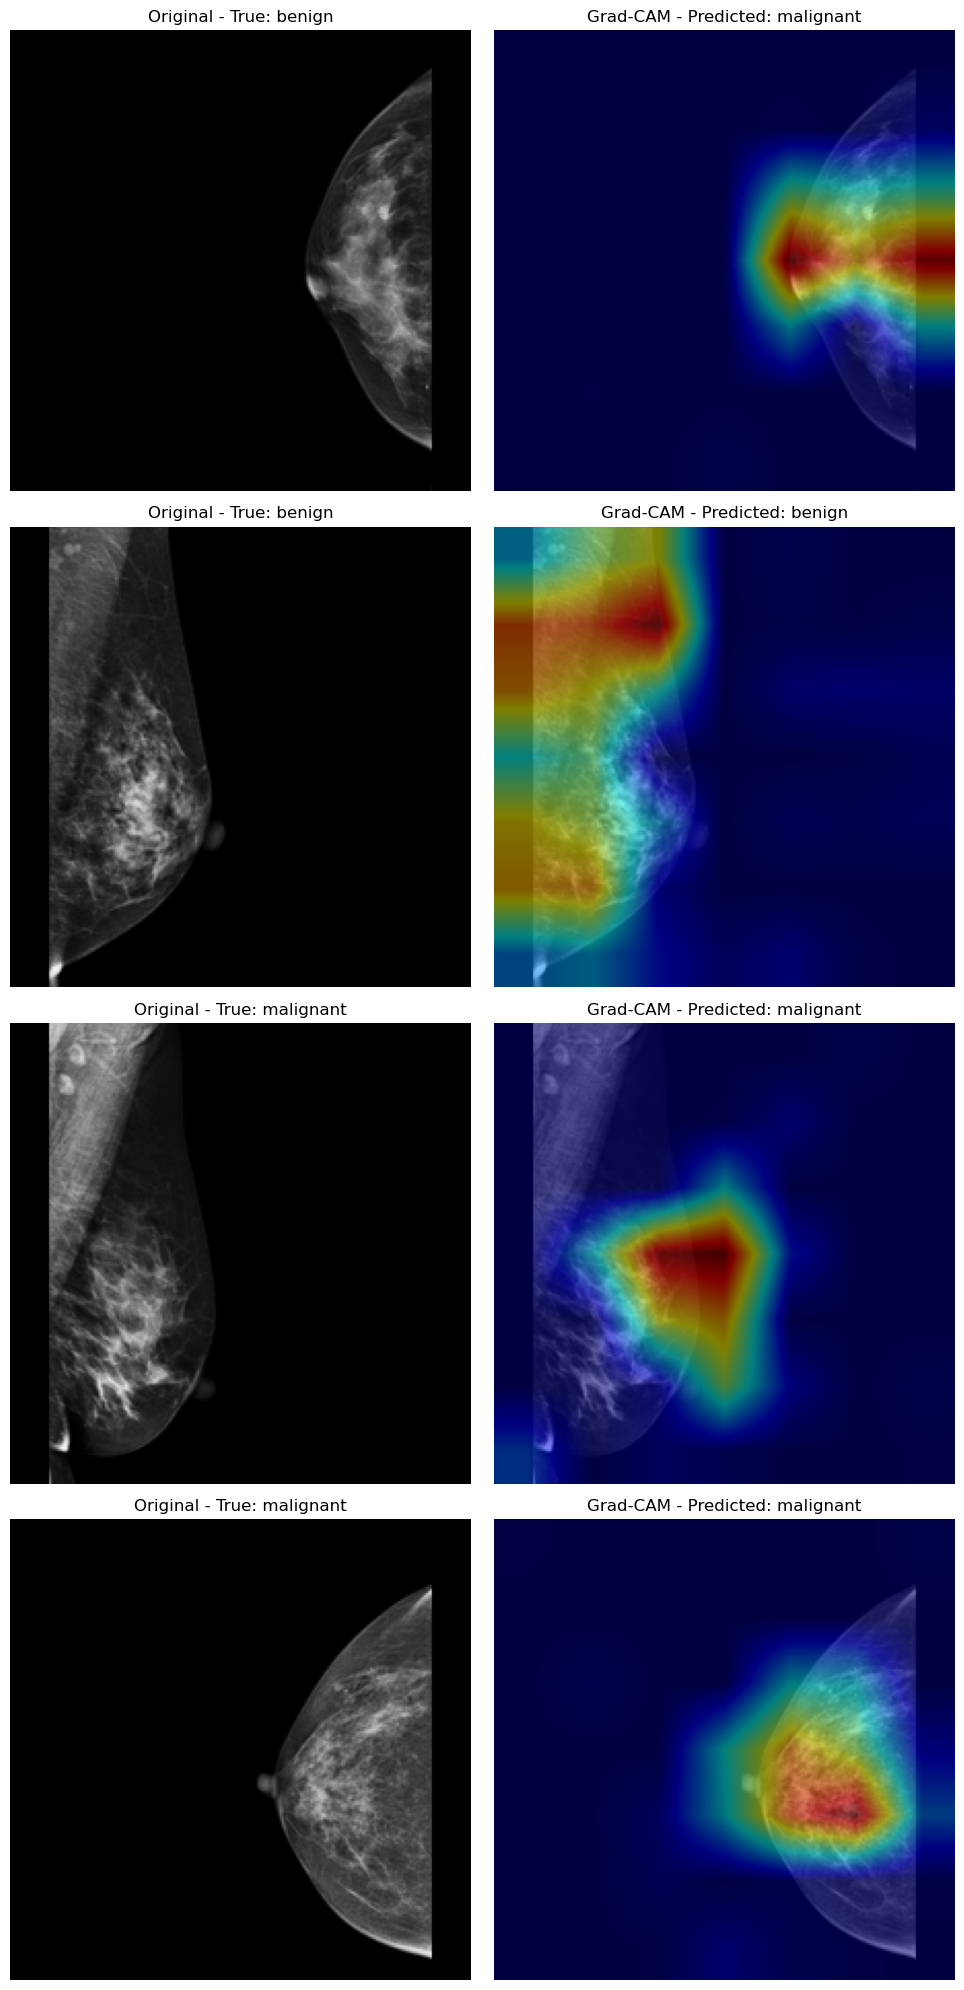

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# =================================================================
# BƯỚC 1: ĐỊNH NGHĨA CÁC HÀM CẦN THIẾT
# =================================================================

def create_mobilenet_model(num_classes: int, img_height=224, img_width=224):
    """
    Hàm tạo model MobileNet.
    Model này nhận đầu vào là ảnh xám (1 kênh) và tự chuyển thành 3 kênh.
    """
    # Đầu vào của model tổng thể là 1 kênh
    final_model_input_layer = Input(shape=(img_height, img_width, 1))
    
    # Nhân bản thành 3 kênh để đưa vào MobileNet base
    tensor_fed_to_mobilenet_base = Concatenate()([
        final_model_input_layer, 
        final_model_input_layer, 
        final_model_input_layer
    ])

    # Khởi tạo MobileNetV2 base
    base_mobilenet_app = MobileNetV2(input_tensor=tensor_fed_to_mobilenet_base, 
                                     include_top=False,
                                     weights='imagenet')

    x = base_mobilenet_app.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    if num_classes >= 2:
        out = Dense(num_classes, activation='softmax')(x)
    else: 
        out = Dense(1, activation='sigmoid')(x)
            
    final_model = Model(inputs=final_model_input_layer, outputs=out)
            
    return final_model

def get_image_paths_and_labels(data_dir, label_encoder):
    """
    Hàm này chỉ lấy đường dẫn file, không tải ảnh, giúp tiết kiệm RAM.
    """
    filepaths, labels = [], []
    class_names = label_encoder.classes_
    print(f"Bắt đầu quét thư mục: {data_dir}")
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"[Cảnh báo] Không tìm thấy thư mục lớp: '{class_name}'")
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    print(f"Đã tìm thấy {len(filepaths)} ảnh.")
    return filepaths, label_encoder.transform(labels)

def make_gradcam_heatmap(model, img_array, last_conv_layer_name):
    """
    Hàm Grad-CAM phiên bản đơn giản và ổn định.
    Nó hoạt động tốt với cấu trúc model "phẳng" của bạn.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(original_img_rgb, heatmap, alpha=0.5):
    """Hàm trộn màu heatmap lên ảnh gốc."""
    heatmap_resized = cv2.resize(heatmap, (original_img_rgb.shape[1], original_img_rgb.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Chuyển ảnh gốc sang kiểu float32 để trộn
    img_float = original_img_rgb.astype(np.float32)
    heatmap_float = heatmap_color_rgb.astype(np.float32)
    
    superimposed_img = heatmap_float * alpha + img_float * (1 - alpha)
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)


# =================================================================
# BƯỚC 2: THIẾT LẬP VÀ CHẠY QUY TRÌNH
# =================================================================

# --- 1. Cấu hình đường dẫn ---
MODEL_PATH = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/saved_models/dataset-CMMD_type-all_model-MobileNet_lr-0.001_b-16_e1-50_e2-50_roi-False_CMMD_MobileNet_ReducedParams_Elastic2.h5'
DATA_DIR = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD'
LAST_CONV_LAYER_NAME = "out_relu" # Lớp kích hoạt cuối cùng trong MobileNetV2 base

# --- 2. Tải model ---
print("--- Tải lại mô hình MobileNet ---")
model_mobilenet = None
if not os.path.exists(MODEL_PATH):
    print(f"[LỖI] Không tìm thấy file model tại: {MODEL_PATH}")
else:
    try:
        model_mobilenet = create_mobilenet_model(num_classes=2)
        model_mobilenet.load_weights(MODEL_PATH)
        print("\n--- Tải thành công model MobileNet ---")
        model_mobilenet.summary()
    except Exception as e:
        print(f"\n[LỖI] KHÔNG THỂ TẢI MODEL: {e}")
        import traceback
        traceback.print_exc()

# --- 3. Tải đường dẫn dữ liệu và visualize ---
if model_mobilenet is not None:
    le_cmmd = LabelEncoder()
    le_cmmd.fit(['benign', 'malignant'])
    
    # ✅ Chỉ lấy đường dẫn, không tải ảnh
    all_filepaths, y_labels = get_image_paths_and_labels(DATA_DIR, le_cmmd)
    
    if len(all_filepaths) > 0:
        _, X_test_filepaths, _, y_test_labels = train_test_split(
            all_filepaths, y_labels, test_size=0.2, stratify=y_labels, random_state=42
        )
        print(f"\nĐã chia xong, có {len(X_test_filepaths)} ảnh trong tập test.")

        # Chọn mẫu để visualize
        benign_indices = np.where(y_test_labels == le_cmmd.transform(['benign'])[0])[0]
        malignant_indices = np.where(y_test_labels == le_cmmd.transform(['malignant'])[0])[0]
        
        if len(benign_indices) >= 2 and len(malignant_indices) >= 2:
            sample_indices = np.concatenate([
                np.random.choice(benign_indices, 2, replace=False),
                np.random.choice(malignant_indices, 2, replace=False)
            ])

            plt.figure(figsize=(10, 5 * len(sample_indices)))
            for i, idx in enumerate(sample_indices):
                # ✅ Tải và xử lý từng ảnh một để tiết kiệm RAM
                image_path = X_test_filepaths[idx]
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Cảnh báo: Không thể đọc ảnh {image_path}")
                    continue
                
                img_resized = cv2.resize(img, (224, 224))
                
                # Chuẩn bị ảnh cho model (thêm chiều batch và channel)
                img_array_for_model = np.expand_dims(img_resized, axis=-1).astype(np.float32)
                img_array_for_model = np.expand_dims(img_array_for_model, axis=0)

                # Dự đoán và tạo heatmap
                preds = model_mobilenet.predict(img_array_for_model)
                heatmap = make_gradcam_heatmap(model_mobilenet, img_array_for_model, LAST_CONV_LAYER_NAME)
                
                # Chuẩn bị ảnh để hiển thị
                predicted_class = le_cmmd.inverse_transform([np.argmax(preds[0])])[0]
                true_class = le_cmmd.inverse_transform([y_test_labels[idx]])[0]
                
                img_to_display = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
                superimposed_img = display_gradcam(img_to_display, heatmap)

                # Vẽ kết quả
                plt.subplot(len(sample_indices), 2, 2*i + 1)
                plt.imshow(img_to_display)
                plt.title(f"Original - True: {true_class}")
                plt.axis('off')

                plt.subplot(len(sample_indices), 2, 2*i + 2)
                plt.imshow(superimposed_img)
                plt.title(f"Grad-CAM - Predicted: {predicted_class}")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("Không đủ mẫu 'Benign' hoặc 'Malignant' trong tập test để visualize.")
    else:
        print("Không tìm thấy ảnh nào, không thể thực hiện visualization.")

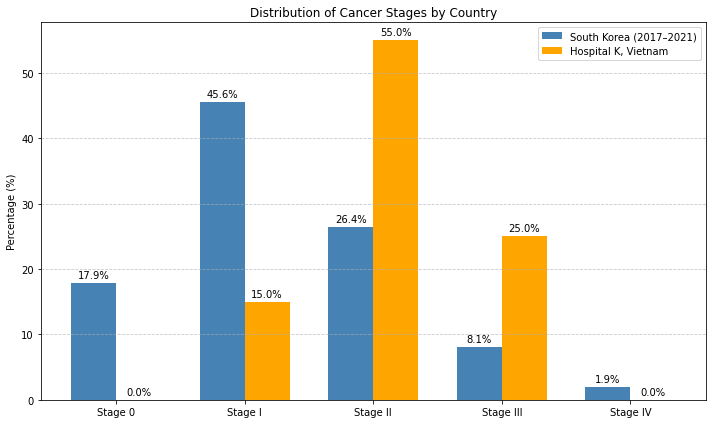

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Stage labels
stages = ['Stage 0', 'Stage I', 'Stage II', 'Stage III', 'Stage IV']
x = np.arange(len(stages))  # Bar positions

# South Korea data
sk_data = [17.9, 45.6, 26.4, 8.1, 1.9]

# Vietnam data (approximate midpoints used for ranges or best estimate)
vn_data = [0, 15, 55, 25, 0]  # Note: Stage III includes Stage IV

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, sk_data, width, label='South Korea (2017–2021)', color='steelblue')
bar2 = ax.bar(x + width/2, vn_data, width, label='Hospital K, Vietnam', color='orange')

# Labels and formatting
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of Cancer Stages by Country')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


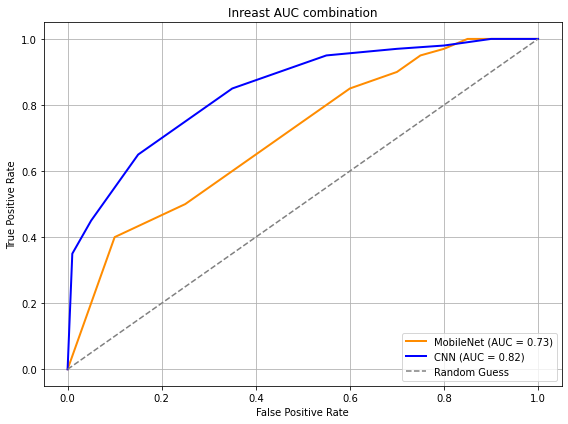

In [4]:
import matplotlib.pyplot as plt

# Approximated ROC data (visually extracted)
# MobileNet (AUC = 0.73)
fpr_mobilenet = [0.0, 0.05, 0.1, 0.25, 0.35, 0.45, 0.55, 0.6, 0.7, 0.75, 0.8, 0.85, 1.0]
tpr_mobilenet = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 1.0, 1.0]
auc_mobilenet = 0.73

# CNN (AUC = 0.82)
fpr_cnn = [0.0, 0.01, 0.05, 0.1, 0.15, 0.25, 0.35, 0.45, 0.55, 0.7, 0.8, 0.9, 1.0]
tpr_cnn = [0.0, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 0.95, 0.97, 0.98, 1.0, 1.0]
auc_cnn = 0.82

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_mobilenet, tpr_mobilenet, color='darkorange', label=f'MobileNet (AUC = {auc_mobilenet:.2f})', linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'CNN (AUC = {auc_cnn:.2f})', linewidth=2)

# Random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Inreast AUC combination')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


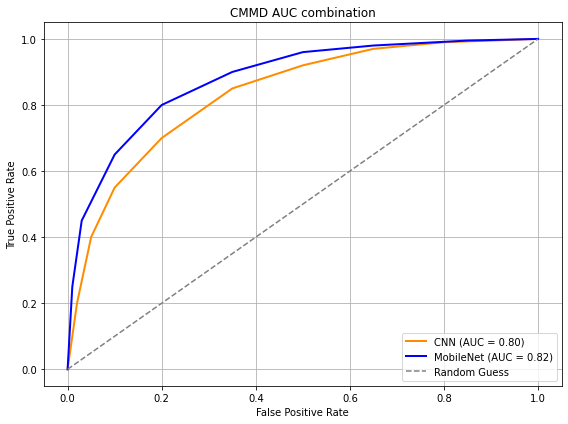

In [1]:
import matplotlib.pyplot as plt

# Approximated ROC data from images

# CNN model (AUC = 0.80)
fpr_cnn = [0.0, 0.02, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]
tpr_cnn = [0.0, 0.2, 0.4, 0.55, 0.7, 0.85, 0.92, 0.97, 0.99, 1.0]
auc_cnn = 0.80

# MobileNet model (AUC = 0.82)
fpr_mobilenet = [0.0, 0.01, 0.03, 0.1, 0.2, 0.35, 0.5, 0.65, 0.85, 1.0]
tpr_mobilenet = [0.0, 0.25, 0.45, 0.65, 0.8, 0.9, 0.96, 0.98, 0.995, 1.0]
auc_mobilenet = 0.82

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', label=f'CNN (AUC = {auc_cnn:.2f})', linewidth=2)
plt.plot(fpr_mobilenet, tpr_mobilenet, color='blue', label=f'MobileNet (AUC = {auc_mobilenet:.2f})', linewidth=2)

# Random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CMMD AUC combination')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 3.0 MB/s eta 0:00:0000:0100:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import sys
import os

# Thêm đường dẫn project vào python path để đảm bảo import đúng
# Giả sử file này nằm ở thư mục gốc của project
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))

try:
    import config
    from cnn_models.mobilenet_v2 import create_mobilenet_model
    import tensorflow as tf
except ImportError as e:
    print(f"Lỗi import: {e}")
    print("Hãy đảm bảo bạn chạy file này từ thư mục gốc của project.")
    sys.exit()

print("--- Bắt đầu kiểm tra model ---")
try:
    # Thiết lập config tối thiểu cần thiết
    config.MOBILE_NET_IMG_SIZE = {'HEIGHT': 224, 'WIDTH': 224}

    # Tạo model
    print(">>> Đang gọi create_mobilenet_model...")
    model = create_mobilenet_model(num_classes=2)
    print(">>> Model đã được tạo thành công.")

    # KIỂM TRA QUAN TRỌNG NHẤT
    # Kiểm tra xem model có phải là một list (có nhiều output) hay không
    if isinstance(model.outputs, list):
        num_outputs = len(model.outputs)
    else:
        num_outputs = 1
        
    print(f"\n*** SỐ LƯỢNG OUTPUT CỦA MODEL: {num_outputs} ***\n")

    if num_outputs == 2:
        print(">>> TUYỆT VỜI! Model của bạn đã được tạo đúng với 2 output.")
        print(">>> Vấn đề có thể nằm ở script Grad-CAM chính.")
    else:
        print(">>> LỖI: Model chỉ có 1 output.")
        print(">>> NGUYÊN NHÂN: File mobilenet_v2.py chưa được cập nhật đúng cách hoặc cache cũ đang được sử dụng.")
        print(">>> HÃY THỰC HIỆN BƯỚC 2 DƯỚI ĐÂY.")


except Exception as e:
    print(f"!!! Đã xảy ra lỗi trong quá trình kiểm tra: {e}")
    import traceback
    traceback.print_exc()

print("\n--- Kết thúc kiểm tra ---")

--- Bắt đầu kiểm tra model ---
>>> Đang gọi create_mobilenet_model...
>>> Model đã được tạo thành công.

*** SỐ LƯỢNG OUTPUT CỦA MODEL: 1 ***

>>> LỖI: Model chỉ có 1 output.
>>> NGUYÊN NHÂN: File mobilenet_v2.py chưa được cập nhật đúng cách hoặc cache cũ đang được sử dụng.
>>> HÃY THỰC HIỆN BƯỚC 2 DƯỚI ĐÂY.

--- Kết thúc kiểm tra ---


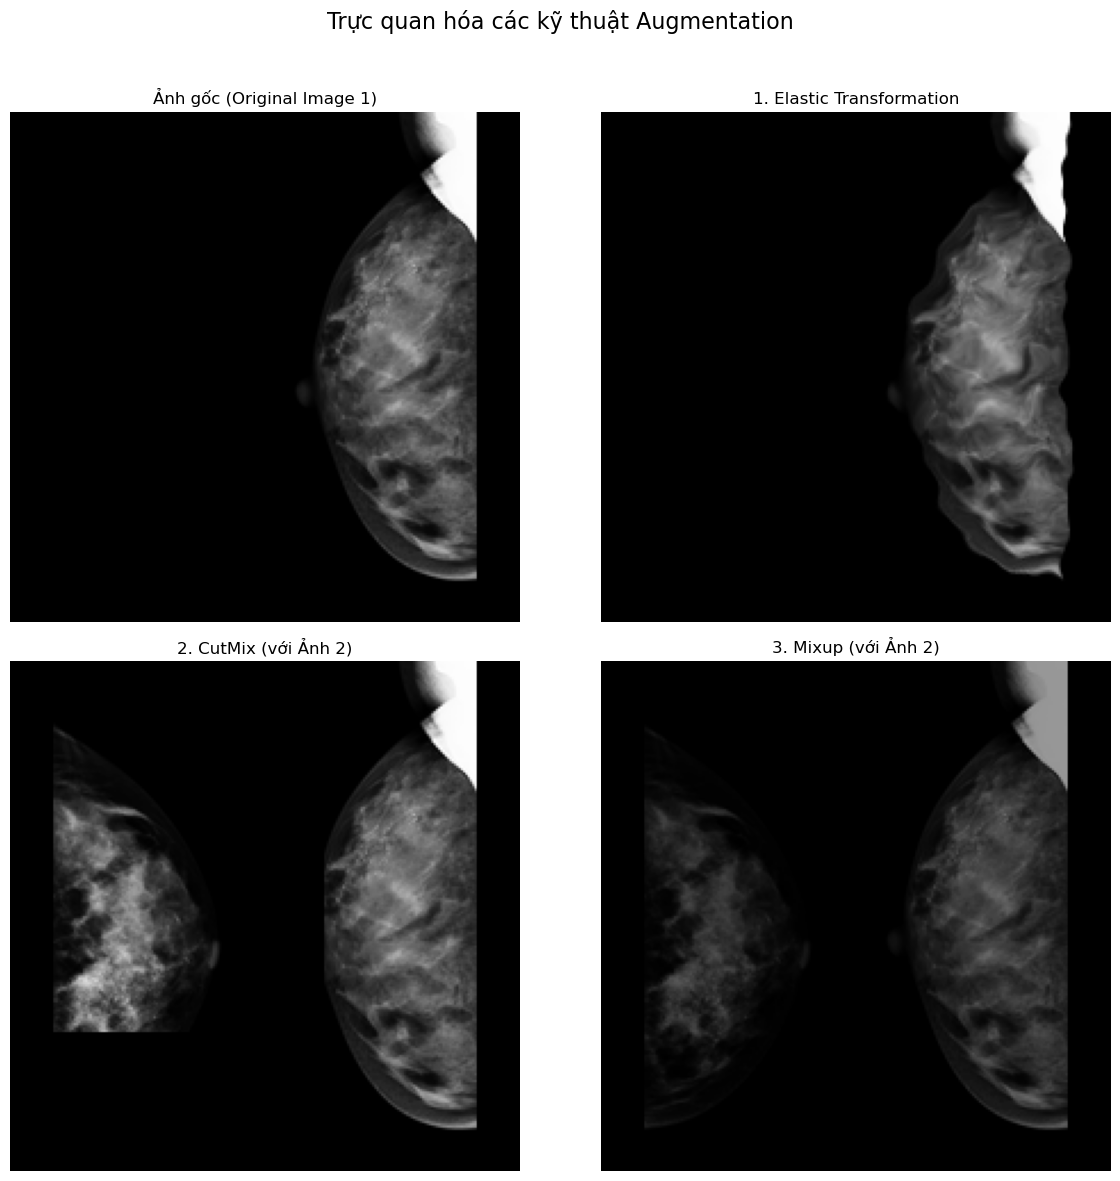

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# =================================================================
# --- 1. CẤU HÌNH -------------------------------------------------
# =================================================================
# ✅ THAY ĐỔI ĐƯỜNG DẪN DƯỚI ĐÂY để trỏ đến ảnh của bạn

# Ảnh chính để áp dụng Elastic Transformation
IMAGE_PATH_1 = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD/malignant/D1-0051_1-2.png' 

# Ảnh thứ hai để dùng cho CutMix và Mixup
IMAGE_PATH_2 = '/home/neeyuhuynh/Desktop/Breast-Cancer-Detection-Mammogram-Deep-Learning-Publication/data/CMMD/malignant/D1-0064_1-1.png' 

# =================================================================
# --- 2. CÁC HÀM TĂNG CƯỜNG DỮ LIỆU (AUGMENTATION) ----------------
# =================================================================

def elastic_transform(image, alpha, sigma, random_state=None):
    """
    Thực hiện biến dạng co giãn (Elastic Transformation) trên ảnh.
    
    :param image: Ảnh đầu vào (dạng NumPy array).
    :param alpha: Cường độ biến dạng.
    :param sigma: Độ mượt của biến dạng (Gaussian filter standard deviation).
    :param random_state: Trạng thái ngẫu nhiên để có kết quả lặp lại.
    :return: Ảnh đã được biến dạng.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    # Tạo các trường dịch chuyển ngẫu nhiên
    dx = cv2.GaussianBlur((random_state.rand(*shape[:2]) * 2 - 1), (0,0), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape[:2]) * 2 - 1), (0,0), sigma) * alpha
    
    # Tạo lưới tọa độ gốc
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Áp dụng trường dịch chuyển vào lưới và thực hiện remap
    map_x = (x + dx).astype('float32')
    map_y = (y + dy).astype('float32')
    
    # is_rgb = len(shape) == 3
    # if is_rgb:
    #     map_x = np.broadcast_to(map_x[..., np.newaxis], shape)
    #     map_y = np.broadcast_to(map_y[..., np.newaxis], shape)
        
    transformed_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    return transformed_image


def cutmix(image1, image2, lam=0.4):
    """
    Thực hiện CutMix: Cắt một vùng từ ảnh 2 và dán vào ảnh 1.
    
    :param image1: Ảnh nền.
    :param image2: Ảnh để cắt.
    :param lam: Tỷ lệ của vùng cắt so với toàn ảnh.
    :return: Ảnh đã được CutMix.
    """
    h, w, _ = image1.shape
    
    # Tính toán bounding box
    r_x = np.random.randint(w)
    r_y = np.random.randint(h)
    r_w = int(w * np.sqrt(1 - lam))
    r_h = int(h * np.sqrt(1 - lam))
    
    x1 = np.clip(r_x - r_w // 2, 0, w)
    y1 = np.clip(r_y - r_h // 2, 0, h)
    x2 = np.clip(r_x + r_w // 2, 0, w)
    y2 = np.clip(r_y + r_h // 2, 0, h)

    # Tạo một bản sao của ảnh 1 để dán
    mixed_image = image1.copy()
    # Dán vùng cắt từ ảnh 2 vào
    mixed_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]
    
    return mixed_image


def mixup(image1, image2, lam=0.6):
    """
    Thực hiện Mixup: Trộn hai ảnh với nhau theo một tỷ lệ.
    
    :param image1: Ảnh thứ nhất.
    :param image2: Ảnh thứ hai.
    :param lam: Tỷ lệ trộn (alpha trong công thức gốc).
    :return: Ảnh đã được Mixup.
    """
    # Đảm bảo cả hai ảnh có cùng kiểu dữ liệu để trộn
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    
    mixed_image = lam * image1 + (1 - lam) * image2
    
    # Chuyển về kiểu dữ liệu uint8 để hiển thị
    return mixed_image.astype(np.uint8)


# =================================================================
# --- 3. TẢI ẢNH, ÁP DỤNG VÀ TRỰC QUAN HÓA -----------------------
# =================================================================

def main():
    # Tải ảnh từ đường dẫn và chuyển sang hệ màu RGB
    try:
        img1 = cv2.imread(IMAGE_PATH_1)
        if img1 is None:
            raise FileNotFoundError(f"Không thể đọc ảnh tại: {IMAGE_PATH_1}")
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        img2 = cv2.imread(IMAGE_PATH_2)
        if img2 is None:
            raise FileNotFoundError(f"Không thể đọc ảnh tại: {IMAGE_PATH_2}")
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    except FileNotFoundError as e:
        print(f"Lỗi: {e}")
        print("Vui lòng kiểm tra lại đường dẫn file ảnh trong phần CẤU HÌNH.")
        return

    # Đảm bảo hai ảnh có cùng kích thước để Mixup và CutMix
    if img1.shape != img2.shape:
        print("Cảnh báo: Hai ảnh có kích thước khác nhau. Thay đổi kích thước ảnh 2 cho khớp với ảnh 1.")
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # --- Áp dụng các kỹ thuật augmentation ---
    
    #  tecniche 1: Elastic Transformation
    # Alpha càng lớn, biến dạng càng mạnh. Sigma càng lớn, biến dạng càng mượt.
    elastic_img = elastic_transform(img1, alpha=35, sigma=4)
    
    # Tecniche 2: CutMix
    cutmix_img = cutmix(img1, img2, lam=0.5)
    
    # Tecniche 3: Mixup
    mixup_img = mixup(img1, img2, lam=0.6)

    # --- Trực quan hóa kết quả ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Trực quan hóa các kỹ thuật Augmentation', fontsize=16)

    axes[0, 0].imshow(img1)
    axes[0, 0].set_title('Ảnh gốc (Original Image 1)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(elastic_img)
    axes[0, 1].set_title('1. Elastic Transformation')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(cutmix_img)
    axes[1, 0].set_title('2. CutMix (với Ảnh 2)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(mixup_img)
    axes[1, 1].set_title('3. Mixup (với Ảnh 2)')
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    main()